# Practice Lab: Neural Networks for Handwritten Digit Recognition, Multiclass 

In this exercise, you will use a neural network to recognize the hand-written digits 0-9.


# Outline
- [ 1 - Packages ](#1)
- [ 2 - ReLU Activation](#2)
- [ 3 - Softmax Function](#3)
  - [ Exercise 1](#ex01)
- [ 4 - Neural Networks](#4)
  - [ 4.1 Problem Statement](#4.1)
  - [ 4.2 Dataset](#4.2)
  - [ 4.3 Model representation](#4.3)
  - [ 4.4 Tensorflow Model Implementation](#4.4)
  - [ 4.5 Softmax placement](#4.5)
    - [ Exercise 2](#ex02)


<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
%matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

from public_tests import * 

from autils import *
from lab_utils_softmax import plt_softmax
np.set_printoptions(precision=2)

<a name="2"></a>
## 2 - ReLU Activation
This week, a new activation was introduced, the Rectified Linear Unit (ReLU). 
$$ a = max(0,z) \quad\quad\text {# ReLU function} $$

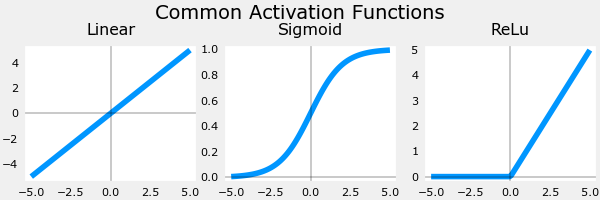

In [3]:
plt_act_trio()

<img align="right" src="./images/C2_W2_ReLu.png"     style=" width:380px; padding: 10px 20px; " >
The example from the lecture on the right shows an application of the ReLU. In this example, the derived "awareness" feature is not binary but has a continuous range of values. The sigmoid is best for on/off or binary situations. The ReLU provides a continuous linear relationship. Additionally it has an 'off' range where the output is zero.     
The "off" feature makes the ReLU a Non-Linear activation. Why is this needed? This enables multiple units to contribute to to the resulting function without interfering. This is examined more in the supporting optional lab. 

<a name="3"></a>
## 3 - Softmax Function
A multiclass neural network generates N outputs. One output is selected as the predicted answer. In the output layer, a vector $\mathbf{z}$ is generated by a linear function which is fed into a softmax function. The softmax function converts $\mathbf{z}$  into a probability distribution as described below. After applying softmax, each output will be between 0 and 1 and the outputs will sum to 1. They can be interpreted as probabilities. The larger inputs to the softmax will correspond to larger output probabilities.
<center>  <img  src="./images/C2_W2_NNSoftmax.png" width="600" />  

The softmax function can be written:
$$a_j = \frac{e^{z_j}}{ \sum_{k=0}^{N-1}{e^{z_k} }} \tag{1}$$

Where $z = \mathbf{w} \cdot \mathbf{x} + b$ and N is the number of feature/categories in the output layer.  

<a name="ex01"></a>
### Exercise 1
Let's create a NumPy implementation:

In [7]:
# UNQ_C1
# GRADED CELL: my_softmax

def my_softmax(z):  
    """ Softmax converts a vector of values to a probability distribution.
    Args:
      z (ndarray (N,))  : input data, N features
    Returns:
      a (ndarray (N,))  : softmax of z
    """    
    ### START CODE HERE ### 

    down = np.exp(z)
    a = down/sum(down)

    ### END CODE HERE ### 
    return a

In [8]:
z = np.array([1., 2., 3., 4.])
a = my_softmax(z)
atf = tf.nn.softmax(z)
print(f"my_softmax(z):         {a}")
print(f"tensorflow softmax(z): {atf}")

# BEGIN UNIT TEST  
test_my_softmax(my_softmax)
# END UNIT TEST  

my_softmax(z):         [0.03 0.09 0.24 0.64]
tensorflow softmax(z): [0.03 0.09 0.24 0.64]
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    One implementation uses for loop to first build the denominator and then a second loop to calculate each output.
    
```python
def my_softmax(z):  
    N = len(z)
    a =                     # initialize a to zeros 
    ez_sum =                # initialize sum to zero
    for k in range(N):      # loop over number of outputs             
        ez_sum +=           # sum exp(z[k]) to build the shared denominator      
    for j in range(N):      # loop over number of outputs again                
        a[j] =              # divide each the exp of each output by the denominator   
    return(a)
```
<details>
  <summary><font size="3" color="darkgreen"><b>Click for code</b></font></summary>
   
```python
def my_softmax(z):  
    N = len(z)
    a = np.zeros(N)
    ez_sum = 0
    for k in range(N):                
        ez_sum += np.exp(z[k])       
    for j in range(N):                
        a[j] = np.exp(z[j])/ez_sum   
    return(a)

Or, a vector implementation:

def my_softmax(z):  
    ez = np.exp(z)              
    a = ez/np.sum(ez)           
    return(a)

```


Below, vary the values of the `z` inputs. Note in particular how the exponential in the numerator magnifies small differences in the values. Note as well that the output values sum to one.

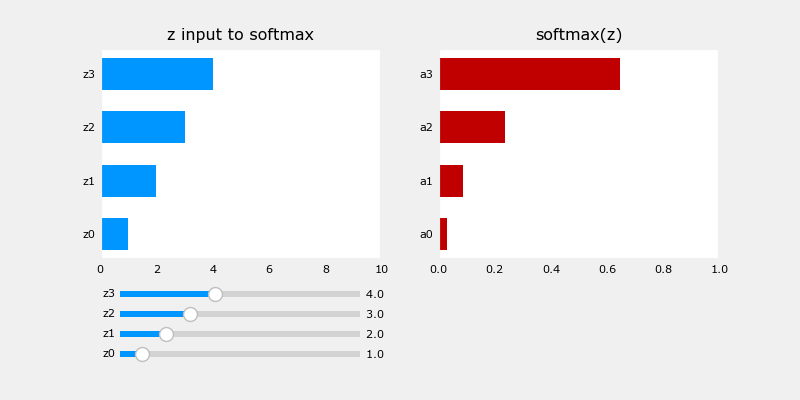

In [9]:
plt.close("all")
plt_softmax(my_softmax)

<a name="4"></a>
## 4 - Neural Networks

In last weeks assignment, you implemented a neural network to do binary classification. This week you will extend that to multiclass classification. This will utilize the softmax activation.


<a name="4.1"></a>
### 4.1 Problem Statement

In this exercise, you will use a neural network to recognize ten handwritten digits, 0-9. This is a multiclass classification task where one of n choices is selected. Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. 


<a name="4.2"></a>
### 4.2 Dataset

You will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into variables `X` and `y`


- The data set contains 5000 training examples of handwritten digits $^1$.  

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit. 
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location. 
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. 
        - Each training examples becomes a single row in our data matrix `X`. 
        - This gives us a 5000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- The second part of the training set is a 5000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 4` if the image is of the digit `4` and so on.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [10]:
# load dataset
X, y = load_data()

#### 4.2.1 View the variables
Let's get more familiar with your dataset.  
- A good place to start is to print out each variable and see what it contains.

The code below prints the first element in the variables `X` and `y`.  

In [11]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2.79e-01  2.74e-01  2.25e-0

In [12]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  9


#### 4.2.2 Check the dimensions of your variables

Another way to get familiar with your data is to view its dimensions. Please print the shape of `X` and `y` and see how many training examples you have in your dataset.

In [13]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


#### 4.2.3 Visualizing the Data

You will begin by visualizing a subset of the training set. 
- In the cell below, the code randomly selects 64 rows from `X`, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together. 
- The label for each image is displayed above the image 

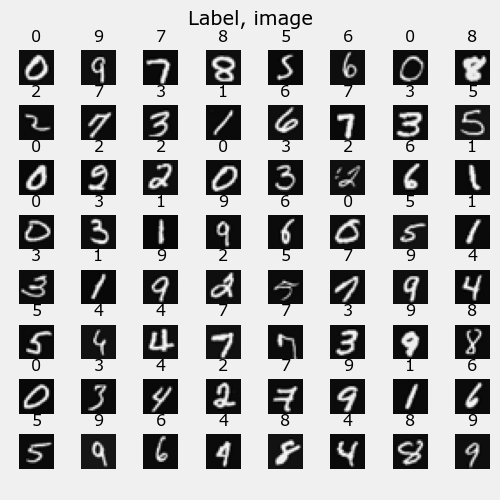

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

<a name="4.3"></a>
### 4.3 Model representation

The neural network you will use in this assignment is shown in the figure below. 
- This has two dense layers with ReLU activations followed by an output layer with a linear activation. 
    - Recall that our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs  
    
<img src="images/C2_W2_Assigment_NN.png" width="600" height="450">

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $10$ output units in layer 3, one for each digit.

    - Recall that the dimensions of these parameters is determined as follows:
        - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then 
            - $W$ will be of dimension $s_{in} \times s_{out}$.
            - $b$ will be a vector with $s_{out}$ elements
  
    - Therefore, the shapes of `W`, and `b`,  are 
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 10) and the shape of `b3` is: (10,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (n,1) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention: 
               

<a name="4.4"></a>
### 4.4 Tensorflow Model Implementation


Tensorflow models are built layer by layer. A layer's input dimensions ($s_{in}$ above) are calculated for you. You specify a layer's *output dimensions* and this determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specified in the `model.fit` statement below. 
>**Note:** It is also possible to add an input layer that specifies the input dimension of the first layer. For example:  
`tf.keras.Input(shape=(400,)),    #specify input shape`  
We will include that here to illuminate some model sizing.

<a name="4.5"></a>
### 4.5 Softmax placement
As described in the lecture and the optional softmax lab, numerical stability is improved if the softmax is grouped with the loss function rather than the output layer during training. This has implications when *building* the model and *using* the model.  
Building:  
* The final Dense layer should use a 'linear' activation. This is effectively no activation. 
* The `model.compile` statement will indicate this by including `from_logits=True`.
`loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) `  
* This does not impact the form of the target. In the case of SparseCategorialCrossentropy, the target is the expected digit, 0-9.

Using the model:
* The outputs are not probabilities. If output probabilities are desired, apply a softmax function.

<a name="ex02"></a>
### Exercise 2

Below, using Keras [Sequential model](https://keras.io/guides/sequential_model/) and [Dense Layer](https://keras.io/api/layers/core_layers/dense/) with a ReLU activation to construct the three layer network described above.

In [23]:
# UNQ_C2
# GRADED CELL: Sequential model
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        ### START CODE HERE ### 
        tf.keras.Input(shape=(400,)),
        tf.keras.layers.Dense(units=25, activation='relu'),
        tf.keras.layers.Dense(units=15, activation='relu'),
        tf.keras.layers.Dense(units=10, activation='linear')

        ### END CODE HERE ### 
    ], name = "my_model" 
)

In [24]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 25)             │        10,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,575 (41.31 KB)

 Trainable params: 10,575 (41.31 KB)

 Non-trainable params: 0 (0.00 B)

<details>
  <summary><font size="3" color="darkgreen"><b>Expected Output (Click to expand)</b></font></summary>
The `model.summary()` function displays a useful summary of the model. Note, the names of the layers may vary as they are auto-generated unless the name is specified.    
    
```
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 25)                10025     
_________________________________________________________________
L2 (Dense)                   (None, 15)                390       
_________________________________________________________________
L3 (Dense)                   (None, 10)                160       
=================================================================
Total params: 10,575
Trainable params: 10,575
Non-trainable params: 0
_________________________________________________________________
```

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
tf.random.set_seed(1234)
model = Sequential(
    [               
        ### START CODE HERE ### 
        tf.keras.Input(shape=(400,)),     # @REPLACE 
        Dense(25, activation='relu', name = "L1"), # @REPLACE 
        Dense(15, activation='relu',  name = "L2"), # @REPLACE  
        Dense(10, activation='linear', name = "L3"),  # @REPLACE 
        ### END CODE HERE ### 
    ], name = "my_model" 
)
``` 

In [22]:
# BEGIN UNIT TEST     
test_model(model, 10, 400)
# END UNIT TEST     

AttributeError: The layer my_model has never been called and thus has no defined input.

The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

Let's further examine the weights to verify that tensorflow produced the same dimensions as we calculated above.

In [25]:
[layer1, layer2, layer3] = model.layers

In [26]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


**Expected Output**
```
W1 shape = (400, 25), b1 shape = (25,)  
W2 shape = (25, 15), b2 shape = (15,)  
W3 shape = (15, 10), b3 shape = (10,)
```

The following code:
* defines a loss function, `SparseCategoricalCrossentropy` and indicates the softmax should be included with the  loss calculation by adding `from_logits=True`)
* defines an optimizer. A popular choice is Adaptive Moment (Adam) which was described in lecture.

In [27]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - loss: 2.0427
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.8793
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.4760
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.3598
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.3022
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.2665
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.2410
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2207
Epoch 9/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2039
Epoch 10/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.1899
Epoch 11/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1776  
Epoch 12/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 0.1668
Epoch 13/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.1568
Epoch 14/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 0.1478
Epoch 15/40
157/157 ━━━━━━━━━━━━━

#### Epochs and batches
In the `compile` statement above, the number of `epochs` was set to 100. This specifies that the entire data set should be applied during training 100 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/100
157/157 [==============================] - 0s 1ms/step - loss: 2.2770
```
The first line, `Epoch 1/100`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 5000 examples in our data set or roughly 157 batches. The notation on the 2nd line `157/157 [====` is describing which batch has been executed.

#### Loss  (cost)
In course 1, we learned to track the progress of gradient descent by monitoring the cost. Ideally, the cost will decrease as the number of iterations of the algorithm increases. Tensorflow refers to the cost as `loss`. Above, you saw the loss displayed each epoch as `model.fit` was executing. The [.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model) method returns a variety of metrics including the loss. This is captured in the `history` variable above. This can be used to examine the loss in a plot as shown below.

In [28]:
plot_loss_tf(history)

NameError: name 'plot_loss_tf' is not defined

#### Prediction 
To make a prediction, use Keras `predict`. Below, X[1015] contains an image of a two.

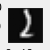

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
 predicting a Two: 
[[ -8.18   1.93   3.78  -1.44 -21.8   -7.34  -6.23  -0.1   -7.14  -9.61]]
 Largest Prediction index: 2


In [29]:
image_of_two = X[1015]
display_digit(image_of_two)

prediction = model.predict(image_of_two.reshape(1,400))  # prediction

print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

The largest output is prediction[2], indicating the predicted digit is a '2'. If the problem only requires a selection, that is sufficient. Use NumPy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to select it. If the problem requires a probability, a softmax is required:

In [30]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

 predicting a Two. Probability vector: 
[[5.41e-06 1.34e-01 8.44e-01 4.60e-03 6.62e-12 1.26e-05 3.81e-05 1.75e-02
  1.53e-05 1.30e-06]]
Total of predictions: 1.000


To return an integer representing the predicted target, you want the index of the largest probability. This is accomplished with the Numpy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function.

In [35]:
yhat = np.argmax(prediction_p)

print(f"np.argmax(prediction_p): {yhat}")

np.argmax(prediction_p): 2


Let's compare the predictions vs the labels for a random sample of 64 digits. This takes a moment to run.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

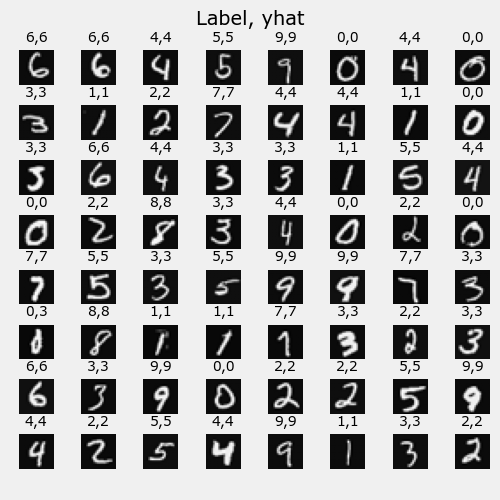

In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}",fontsize=10)
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()

Let's look at some of the errors. 
>Note: increasing the number of training epochs can eliminate the errors on this data set.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
25 errors out of 5000 images


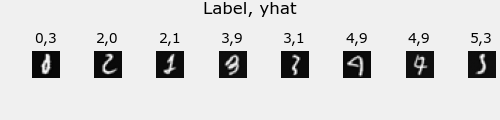

In [33]:
print( f"{display_errors(model,X,y)} errors out of {len(X)} images")

### Congratulations!
You have successfully built and utilized a neural network to do multiclass classification.